In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import datetime
import re
from nltk.corpus import stopwords
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

conn = sqlite3.connect(r"../../diplom.db")
cur = conn.cursor()

In [2]:
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from VEDOMOSTI;""").fetchall()]
graph = [i[0] for text in corpus for i in nltk.bigrams(text) if i[1] == "демократия"]
c = Counter(graph)
adjusting = pd.DataFrame(c.most_common()).rename(columns={0: "Слово", 1: "Количество"})
adjusting["Часть"] = [i[1] for i in nltk.pos_tag(adjusting["Слово"], lang="rus")]
adj = adjusting[adjusting["Часть"].isin(["A=m", "A-PRO=m"])].reset_index(drop=True)
s = adj["Количество"].sum()
adj["Процент"] = round(adj["Количество"]/s*100, 2)

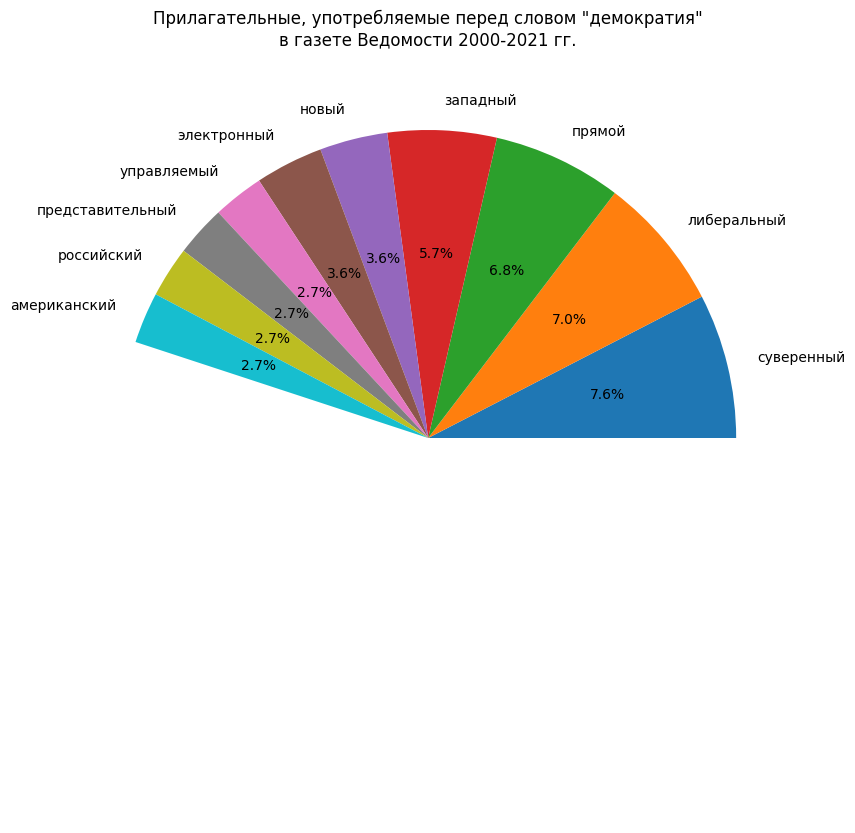

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
rus = adj[["Слово", "Процент"]].head(10)
rus.loc[10, "Слово"] = "Ост."
rus.loc[10, "Процент"] = adj.loc[10:, "Процент"].sum()
wedge, text, procent = ax.pie(rus["Процент"], labels=rus["Слово"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Прилагательные, употребляемые перед словом "демократия"\nв газете Ведомости 2000-2021 гг.')
fig.savefig("vedomosti_adj_ru.png")

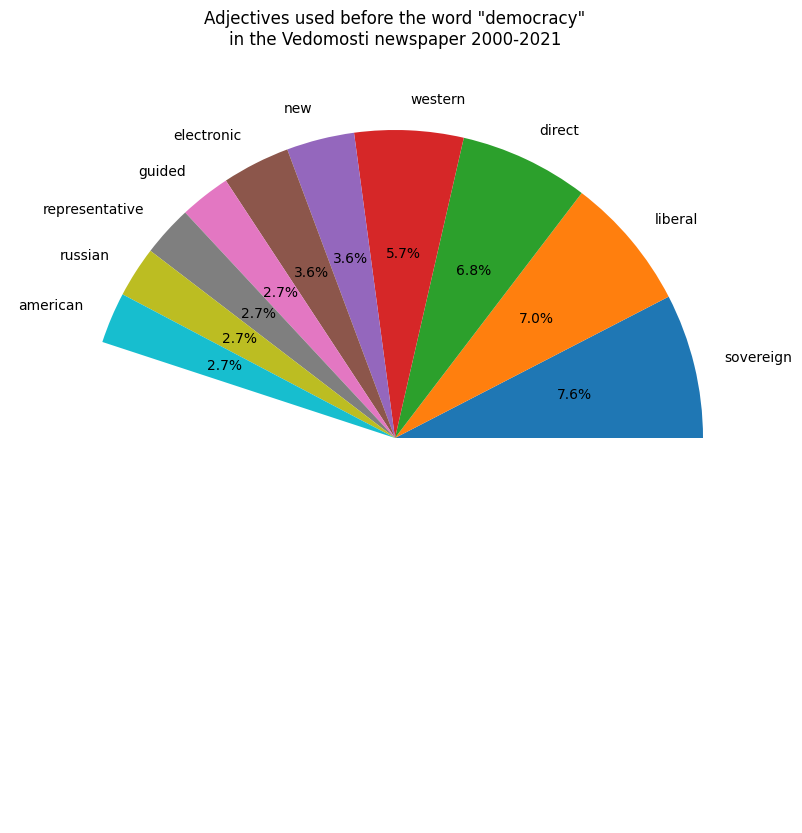

In [4]:
eng = rus.copy()
eng['Word'] = ['sovereign', 'liberal', 'direct', 'western', 'new', 'electronic', 'guided', 'representative', 'russian', 'american', 'rest']
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
wedge, text, procent = ax.pie(rus["Процент"], labels=eng["Word"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Adjectives used before the word "democracy"\nin the Vedomosti newspaper 2000-2021')
fig.savefig("vedomosti_adj_en.png")

In [7]:
%%time
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from VEDOMOSTI""").fetchall()]
model = Word2Vec(corpus, 
                 vector_size=1024,      # embedding vector size
                 min_count=2,
                 window=5)
model.save("vedomosti.model")
model.wv.save("vedomosti.wordvectors")
model.wv.most_similar('демократия')

CPU times: total: 34min 53s
Wall time: 15min 20s


[('автократия', 0.6826958060264587),
 ('авторитаризм', 0.6546353101730347),
 ('демократический', 0.6141847372055054),
 ('капитализм', 0.598501980304718),
 ('социализм', 0.5721936821937561),
 ('диктатура', 0.5570324063301086),
 ('авторитарный', 0.5562959909439087),
 ('демократизация', 0.5516128540039062),
 ('либерализм', 0.549346387386322),
 ('государственность', 0.5486838221549988)]

In [ ]:
cur.close()
conn.close()